# Failing Sensors
State estimation methods typically assumes input measurements to be perfect, or only polluted by random noise. However, in practical applications, sensors may fail or provide erroneous data due to various reasons such as hardware malfunctions, environmental conditions, or communication issues. This notebook addresses this problem following the approach proposed in [Riva et al., 2025](https://doi.org/10.1051/epjn/2025054).

Both the GEIM and the PBDW methods are extended to handle failing sensors. Two kind of failures are considered:
- **Hard failures**: the sensor stops providing data altogether.
- **Drift failures**: the sensor provides erroneous data, e.g., biased measurements, given $\mathbf{y}$ as the true measurement vector (already including "standard noise"), the faulty sensor provides $\mathbf{y}_{\text{faulty}} = \mathbf{y} + \mathcal{N}(\kappa, \rho^2)$ where $\mathcal{N}(\kappa, \rho^2)$ is a Gaussian random variable with mean $\kappa$ and variance $\rho^2$.

In this notebook, we are going to consider a MP simulation of a MSFR, during the Unprotected Loss Of Flow (ULOFF) transient.

## Import OpenFOAM case 
Using *pyforce* functions we can import directly the OpenFOAM case.

In [ ]:
from pyforce.tools.write_read import ReadFromOF

of = ReadFromOF('../Datasets/MSFR-ULOFF')
grid = of.mesh()

# import pyvista as pv

# pl = pv.Plotter()
# pl.add_mesh(grid, color='lightgrey', show_edges=True)
# pl.add_axes()
# pl.add_bounding_box()
# pl.show(jupyter_backend='pythreejs')

Let us load the temperature field

In [2]:
field = 'T'

dataset, times = of.import_field(field)

Let us scale it to [0,1] range for numerical stability

In [3]:
from pyforce.tools.scalers import MinMaxScaler

scaler = MinMaxScaler(global_scale=True)
scaler.fit(dataset)

snapshots = scaler.transform(dataset)

Let us split the data into train and test

In [4]:
from pyforce.tools.functions_list import train_test_split

train_times, test_times, train_snaps, test_snaps = train_test_split(
    times, snapshots, test_size=0.2, random_state=42
)

# Sorting the training snapshots according to time
import numpy as np
_argsort = np.argsort(train_times)
train_times = np.array(train_times)[_argsort]
train_snaps.sort(_argsort)

# Sorting the testing snapshots according to time
_argsort = np.argsort(test_times)
test_times = np.array(test_times)[_argsort]
test_snaps.sort(_argsort)

## GEIM
We first test the GEIM method with failing sensors.

In [5]:
geim_on_abs_err = dict()
geim_on_rel_err = dict()

noise_std = 0.02 # 2% noise

geim_estimation = dict()

### Offline Phase
At first, the GEIM magic functions and sensors are computed in the offline phase.

In [6]:
from pyforce.offline.geim import GEIM as GEIMoffline

geim_off = GEIMoffline(grid, varname=field)

Sensors will be placed everywhere in the domain.

In [7]:
sens_params = {
    's': 0.025, # spread of the Gaussian kernels - hyperparameter to be tuned according to the physical system
    'xm_list': grid.cell_centers().points[::20].tolist() # optional (sampling every 10 points to speed up the process)
}

res_geim_offline = geim_off.fit(train_snaps, Mmax = 20, sensor_params=sens_params,
                                verbose=True)

Creating Gaussian Sensor Library: 100.000 / 100.00% - 0.000567 s/it


Let us plot the sensors just placed

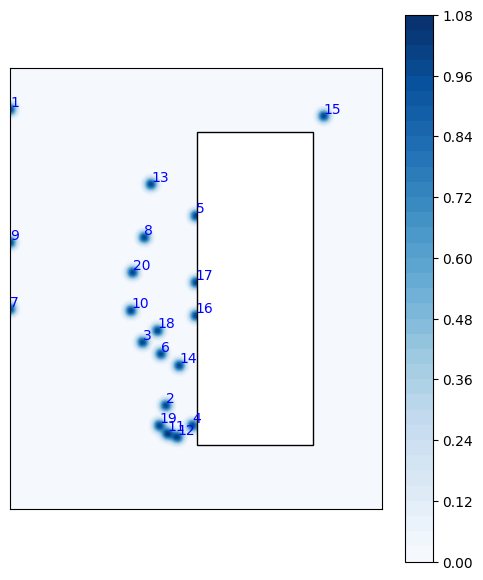

In [8]:
from matplotlib import patches

fig = geim_off.plot_sensors(M=20, levels=40, fig_length=6, fontsize_sens=10,
                                color_sens='blue', cmap='Blues', view='xz')

def get_core_msfr_geometry(ax):

    rect_blanket = patches.Rectangle((1.13, -1.88/2), 0.7, 1.88, linewidth=1, facecolor='white',
                                     edgecolor='black')
    ax.add_patch(rect_blanket)

get_core_msfr_geometry(fig.get_axes()[0])

ax = fig.get_axes()[0]
ax.set_aspect('equal')

### Online Phase: baseline
The baseline is the reconstruction using noisy data, but with all the sensors working. The TR-GEIM version is used.

In [9]:
from pyforce.online.geim import GEIM as GEIMonline

geim_on = GEIMonline(grid, varname=field)
geim_on.set_basis(geim_off.magic_functions)
geim_on.set_magic_sensors(geim_off.magic_sensors.library)

# Assemble matrix for online phase
geim_on.compute_B_matrix()

# Regularisation matrix
geim_on.set_tikhonov_matrices(train_snaps=train_snaps)

Let us compute the errors on the test set

In [10]:
_res = geim_on.compute_errors(test_snaps, noise_std = noise_std,
                            regularization_params = {'type': 'tikhonov', 'lambda': noise_std**2},
                             verbose=True)

geim_on_abs_err['baseline'] = _res[0]
geim_on_rel_err['baseline'] = _res[1]

Computing errors - T: 20.000 / 20.00 - 0.038041 s/it


Let us also estimate the field using all the available sensors (no failing sensors yet)

In [11]:
_measures = geim_on.get_measurements(test_snaps, noise_std=noise_std)
geim_estimation['baseline'] = geim_on.estimate(_measures, 
                                               regularization_params = {'type': 'tikhonov', 'lambda': noise_std**2} )

Let us make a plot of the results

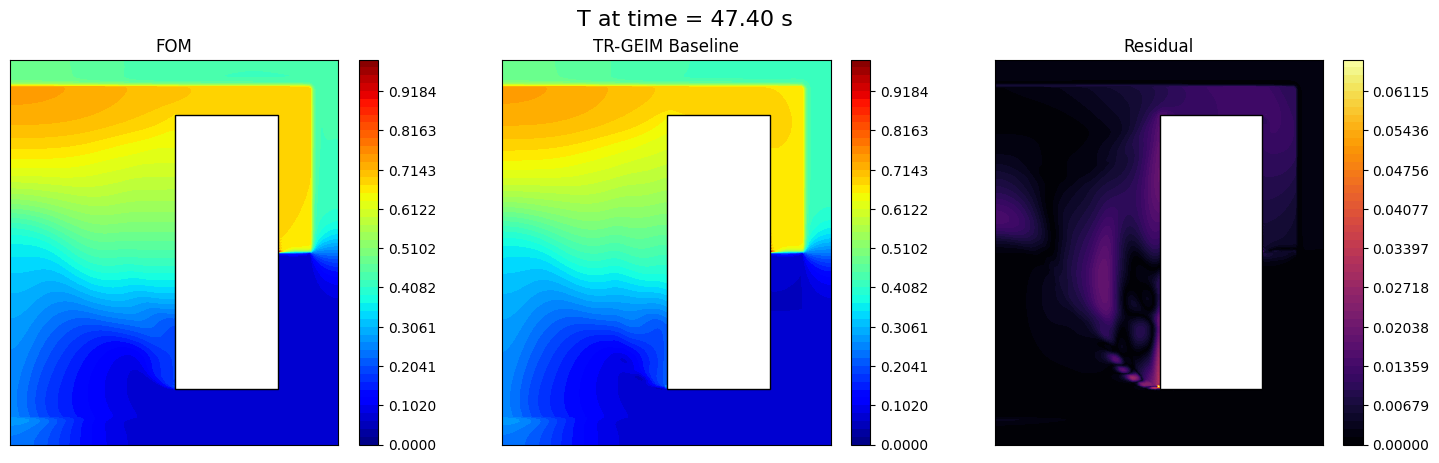

In [12]:
from matplotlib import pyplot as plt
from matplotlib import cm
def plot_contour(ax, domain, _snap, 
                 cmap = cm.jet, levels = 20):
    snap = _snap

    cont = ax.tricontourf(*domain.T, snap, cmap = cmap, levels = levels)

    # Add Blanket
    rect_blanket = patches.Rectangle((1.13, -1.88/2), 0.7, 1.88, linewidth=1, facecolor='white',
                                     edgecolor='black',
                                    zorder=3)

    ax.add_patch(rect_blanket)

    ax.set_xticks([])
    ax.set_yticks([])

    return cont

nodes = grid.cell_centers().points[:, [0, 2]] # x-z plane

from IPython.display import clear_output
for tt in range(0, len(test_times), 10):

    fig, axs = plt.subplots(1, 3, figsize=(6*3,5))

    c = plot_contour(axs[0], nodes, test_snaps[tt],levels = np.linspace(0, 1, 50))
    plot_contour(axs[1], nodes, geim_estimation['baseline'][tt], levels = np.linspace(0, 1, 50))

    fig.colorbar(c, ax=axs[0])
    fig.colorbar(c, ax=axs[1])

    # Residual
    residual = np.abs(test_snaps[tt] - geim_estimation['baseline'][tt])
    c = plot_contour(axs[2], nodes, residual, levels = np.linspace(0, np.max(residual), 50), cmap=cm.inferno)
    fig.colorbar(c, ax=axs[2])

    # Labels
    axs[0].set_title('FOM')
    axs[1].set_title('TR-GEIM Baseline')
    axs[2].set_title('Residual')

    fig.suptitle(field+' at time = %.2f s' % (test_times[tt]), fontsize=16)

    plt.show()
    clear_output(wait=True)
    plt.close(fig)

### Online Phase: failing sensors
Now, we simulate failing sensors. We consider both hard failures and drift failures.

The class is initialized as before.

In [13]:
from pyforce.online.failure_sens import FailingGEIM

failing_geim_on = FailingGEIM(grid, varname=field)

failing_geim_on.set_basis(geim_off.magic_functions)
failing_geim_on.set_magic_sensors(geim_off.magic_sensors.library)

# Assemble matrix for online phase
failing_geim_on.compute_B_matrix()

# Regularisation matrix
failing_geim_on.set_tikhonov_matrices(train_snaps=train_snaps)

**Drift failures** are simulated by adding a bias and variance to the measurements of the failed sensors.

Let us visualize the effect of the drift on measurements

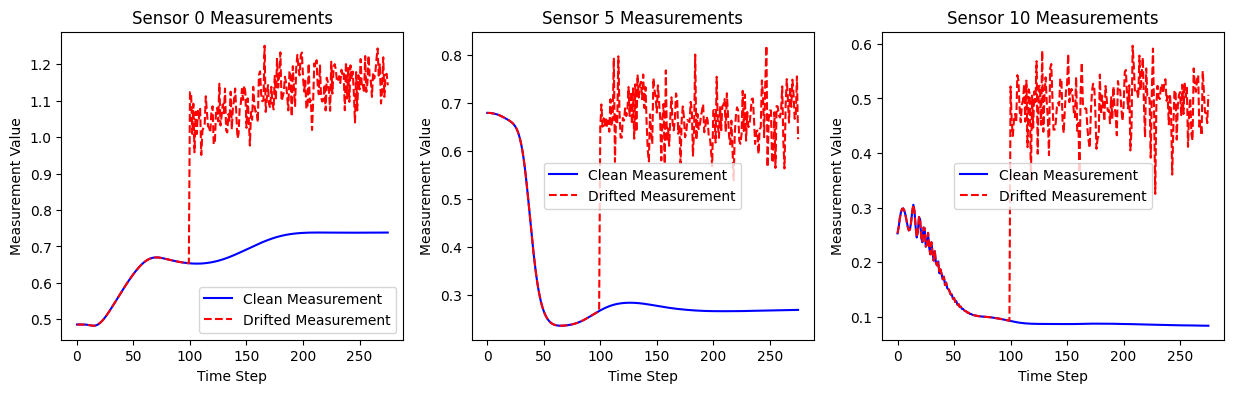

In [14]:
kappa_drift = 0.4 # 10% drift
rho_drift = 0.05 # 5% variance

drift_dict = {
    'kappa': kappa_drift,
    'rho': rho_drift,
    'idx_failed': [0,5,10],
    'mu_failure': 100
}

clean_meas = failing_geim_on.get_measurements(snapshots, noise_std=1e-12)
drifted_meas = failing_geim_on.get_measurements(snapshots, noise_std=1e-12, drift_dict=drift_dict)

fig, axs = plt.subplots(1, len(drift_dict['idx_failed']), figsize=(5 * len(drift_dict['idx_failed']), 4))

for i, idx in enumerate(drift_dict['idx_failed']):
    axs[i].plot(clean_meas[idx], label='Clean Measurement', color='blue')
    axs[i].plot(drifted_meas[idx], label='Drifted Measurement', color='red', linestyle='--')
    axs[i].set_title(f'Sensor {idx} Measurements')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Measurement Value')
    axs[i].legend()

Let us compute the test errors with drift failures on a single sensor. The total number of sensors used is 20 as the number of basis and the influence of the failed index is investigated.

In [15]:
geim_on_abs_err['drift'] = list()
geim_on_rel_err['drift'] = list()
geim_estimation['drift'] = list()

snaps_norm = list()
for _snap in test_snaps:
    snaps_norm.append(failing_geim_on.calculator.L2_norm(_snap))

for kk in range(len(failing_geim_on.basis)):

    print(f"Simulating drift failure on sensor {kk+1}/{len(failing_geim_on.basis)}", end='\r')

    drift_dict = {
        'kappa': kappa_drift,
        'rho': rho_drift,
        'idx_failed': [kk],
        'mu_failure': 0
    }

    drifted_mea = failing_geim_on.get_measurements(test_snaps, noise_std=noise_std, drift_dict=drift_dict)
    geim_estimation['drift'].append(failing_geim_on.estimate(   drifted_mea, 
                                                                regularization_params={'type': 'tikhonov', 'lambda': noise_std**2}))
    
    _abs_err = list()
    _rel_err = list()
    for tt in range(len(test_snaps)):
        _abs_err.append( 
            failing_geim_on.calculator.L2_norm(geim_estimation['drift'][-1](tt) - test_snaps(tt))
        )
        _rel_err.append( 
            _abs_err[-1] / snaps_norm[tt]
        )

    geim_on_abs_err['drift'].append(np.mean(_abs_err))
    geim_on_rel_err['drift'].append(np.mean(_rel_err))

**Hard failures** are simulated by removing the measurements of the failed sensors.

In [16]:
geim_on_abs_err['hard'] = list()
geim_on_rel_err['hard'] = list()
geim_estimation['hard'] = list()

snaps_norm = list()
for _snap in test_snaps:
    snaps_norm.append(failing_geim_on.calculator.L2_norm(_snap))

for kk in range(len(failing_geim_on.basis)):

    print(f"Simulating hard failure on sensor {kk+1}/{len(failing_geim_on.basis)}", end='\r')

    hard_failure_dict = {
        'mu_failure': 0,
        'idx_failed': [kk]
    }

    # Get measurements
    measures = failing_geim_on.get_measurements(test_snaps, noise_std=noise_std)

    # Estimate the state
    geim_estimation['hard'].append(
        failing_geim_on.estimate(   measures, 
                                    regularization_params = {'type': 'tikhonov', 'lambda': noise_std**2},
                                    hard_failure_dict=hard_failure_dict)
                                    )

    # Compute errors

    _abs_err = list()
    _rel_err = list()
    for tt in range(len(test_snaps)):
        _abs_err.append( 
            failing_geim_on.calculator.L2_norm(geim_estimation['hard'][-1](tt) - test_snaps(tt))
        )
        _rel_err.append( 
            _abs_err[-1] / snaps_norm[tt]
        )

    geim_on_abs_err['hard'].append(np.mean(_abs_err))
    geim_on_rel_err['hard'].append(np.mean(_rel_err))

Let us plot the errors obtained with drift failures, with respect to the baseline (no failing sensors)

Text(0.5, 0.98, 'GEIM with Failing Sensors')

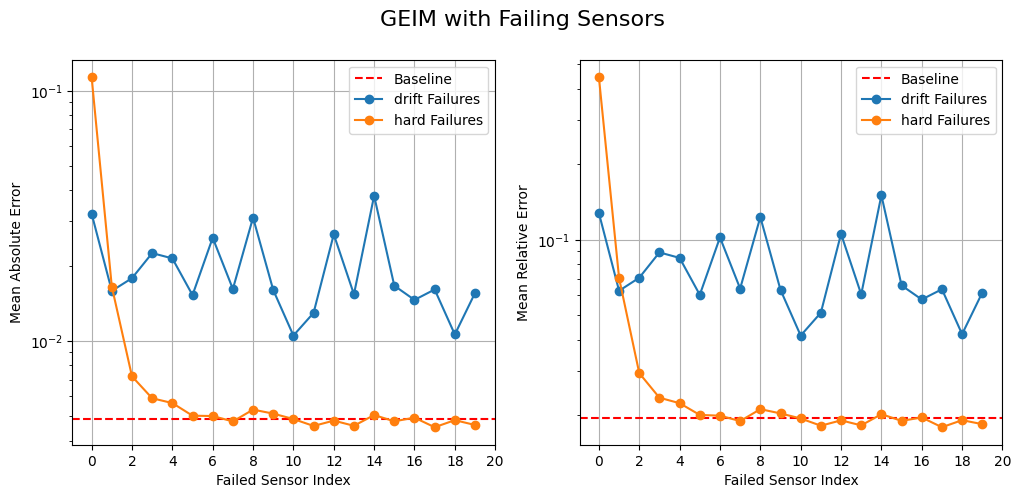

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Baseline
axs[0].axhline(geim_on_abs_err['baseline'][-1], color='red', linestyle='--', label='Baseline')
axs[1].axhline(geim_on_rel_err['baseline'][-1], color='red', linestyle='--', label='Baseline')

# Drift failures
for failure in ['drift', 'hard']:
    axs[0].plot(geim_on_abs_err[failure], marker='o', label=failure + ' Failures')
    axs[1].plot(geim_on_rel_err[failure], marker='o', label=failure + ' Failures')

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_xticks(range(0, len(failing_geim_on.basis)+1, 2))
    ax.set_xlabel('Failed Sensor Index')
    ax.set_yscale('log')

axs[0].set_ylabel('Mean Absolute Error')
axs[1].set_ylabel('Mean Relative Error')

fig.suptitle('GEIM with Failing Sensors', fontsize=16)

Let us make a plot of the reconstructions

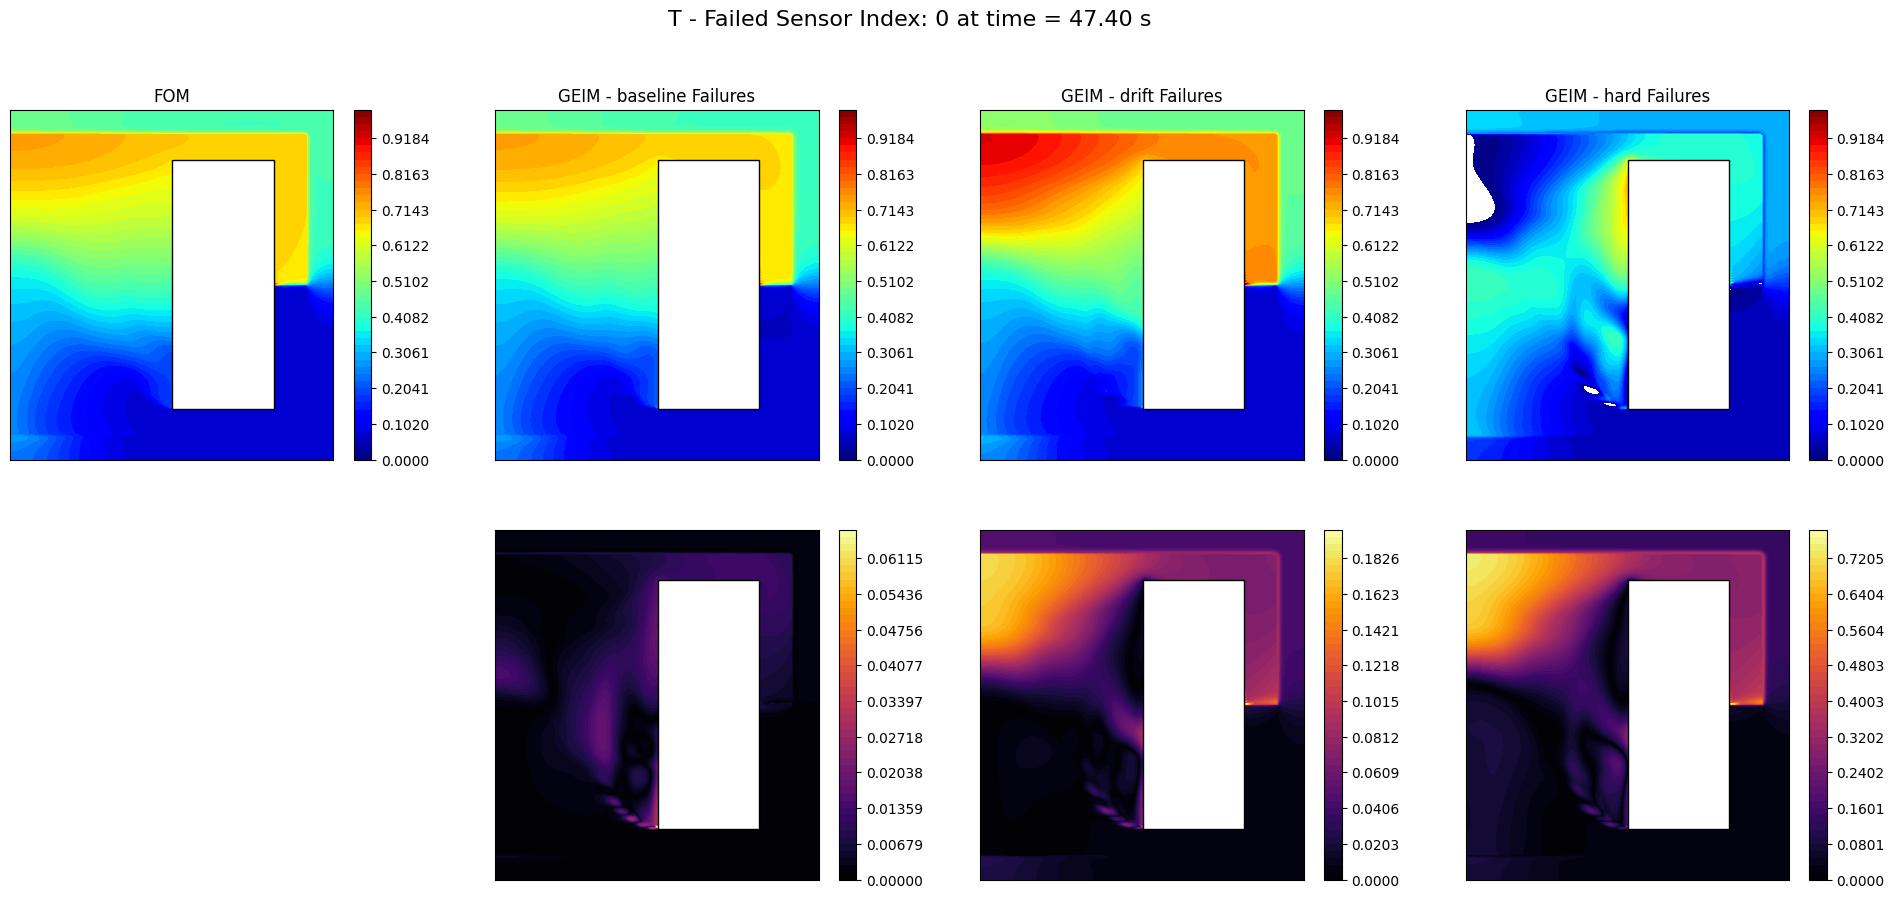

In [51]:
from IPython.display import clear_output

ncols = len(geim_estimation)+1
nrows = 2

_idx_failed_to_plot = 0

for tt in range(0, len(test_times), 10):

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5 * nrows))

    c = plot_contour(axs[0,0], nodes, test_snaps[tt],levels = np.linspace(0, 1, 50))
    fig.colorbar(c, ax=axs[0,0])
    axs[0,0].set_title('FOM')

    for i, (key, estimation) in enumerate(geim_estimation.items()):

        if key == 'baseline':
            _est = estimation
        else:
            _est = estimation[_idx_failed_to_plot]

        c = plot_contour(axs[0,i+1], nodes, _est[tt], levels = np.linspace(0, 1, 50))
        fig.colorbar(c, ax=axs[0, i+1])

        # Residual
        residual = np.abs(test_snaps[tt] - _est[tt])
        c = plot_contour(axs[1,i+1], nodes, residual, levels = np.linspace(0, np.max(residual), 50), cmap=cm.inferno)
        fig.colorbar(c, ax=axs[1,i+1])

        axs[0, i+1].set_title(f'GEIM - {key} Failures')

    fig.suptitle(field+' - Failed Sensor Index: %d at time = %.2f s' % (_idx_failed_to_plot, test_times[tt]), fontsize=16)
    axs[1,0].axis('off')

    plt.show()
    clear_output(wait=True)
    plt.close(fig)

## PBDW
We now test the PBDW method with failing sensors. We are going to use the POD basis for the background space, and the SGREEDY sensors for the update space.

In [18]:
pbdw_on_abs_err = dict()
pbdw_on_rel_err = dict()

pbdw_estimation = dict()

### Offline Phase
At first, the POD basis for the background space is computed in the offline phase.

In [19]:
from pyforce.offline.pod import POD

pod_off = POD(grid, varname=field)
pod_off.fit(train_snaps, verbose=True)

Computing T correlation matrix: 220.000 / 220.00 - 0.005787 s/it
Eigenvalues calculated in 1.286165 seconds.


Let us plot the singular values decay

/var/folders/rq/_c546f811656mn_2__gt6l_00000gn/T/ipykernel_2058/311611219.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pod_off.plot_eigenvalues().show()


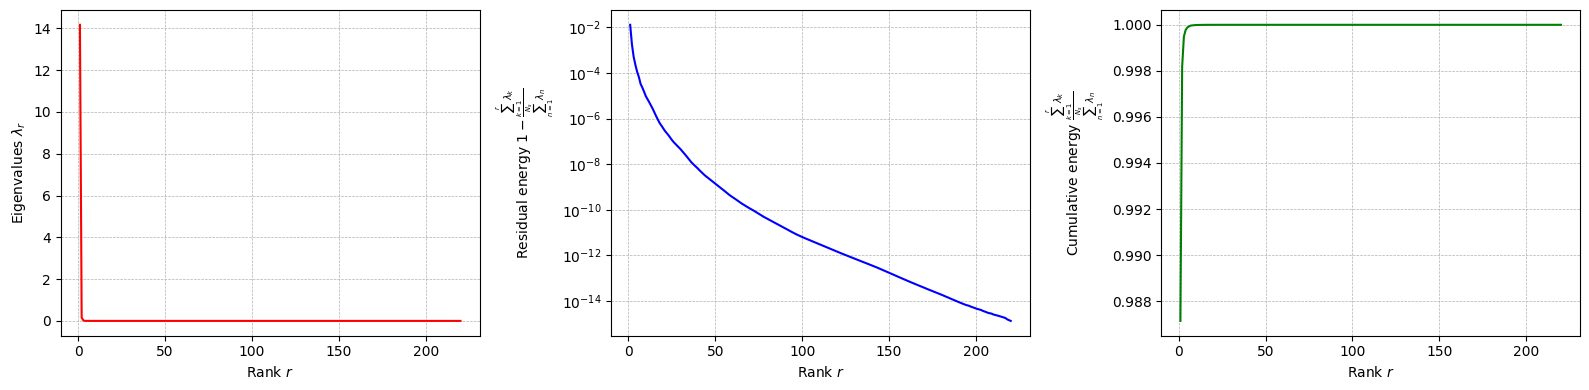

In [20]:
pod_off.plot_eigenvalues().show()

Let us compute the POD modes

In [21]:
pod_off.compute_basis(train_snaps, rank=10)

Let us place the sensors using the SGREED algorithm on the POD basis

In [22]:
from pyforce.offline.sgreedy import SGREEDY

sens_params = {
    's': 0.025, # spread of the Gaussian kernels - hyperparameter to be tuned according to the physical system
    'xm_list': grid.cell_centers().points[::20].tolist() # optional (sampling every 10 points to speed up the process)
}

sgreedy_off = SGREEDY(grid, varname=field)
sgreedy_off.fit(pod_off.pod_modes, Mmax=20, verbose=True,
                sensor_params=sens_params)

Creating Gaussian Sensor Library: 100.000 / 100.00% - 0.000581 s/it


Let us plot the sensors

/Users/sriva/miniconda3/envs/pyforce-env/lib/python3.10/site-packages/pyforce/offline/sgreedy.py:267: UserWarning: The following kwargs were not used by contour: 'show_edges'
  sc = axs.tricontourf(*nodes.T, _cumulative, cmap=cmap, levels=levels, show_edges=False)


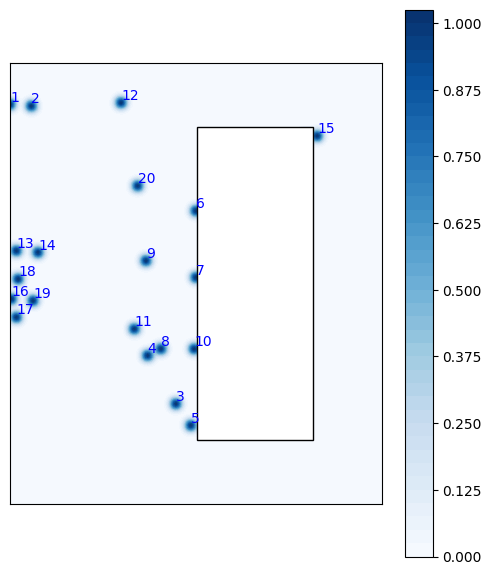

In [23]:
fig = sgreedy_off.plot_sensors(M=20, levels=40, fig_length=6, fontsize_sens=10,
                                color_sens='blue', cmap='Blues', view='xz')

get_core_msfr_geometry(fig.get_axes()[0])

ax = fig.get_axes()[0]
ax.set_aspect('equal')

### Online Phase: baseline
The baseline is the reconstruction using noisy data, but with all the sensors working.

In [24]:
from pyforce.online.pbdw import PBDW as PBDWonline

pbdw_on = PBDWonline(grid, varname=field)
pbdw_on.set_basis(pod_off.pod_modes)
pbdw_on.set_basis_sensors(sgreedy_off.sensors.library)

# Assemble matrix for online phase
pbdw_on.compute_matrices()

Let us compute the errors on the test set

In [25]:
_res = pbdw_on.compute_errors(  test_snaps, noise_std = noise_std,
                                verbose=True)

pbdw_on_abs_err['baseline'] = _res[0]
pbdw_on_rel_err['baseline'] = _res[1]

Computing errors - T: 11.000 / 11.00 - 0.054644 s/it


Let us also estimate the field using all the available sensors (no failing sensors yet)

In [26]:
_measures = pbdw_on.get_measurements(test_snaps, noise_std=noise_std)
pbdw_estimation['baseline'] = pbdw_on.estimate(_measures)

Let us make a plot of the results

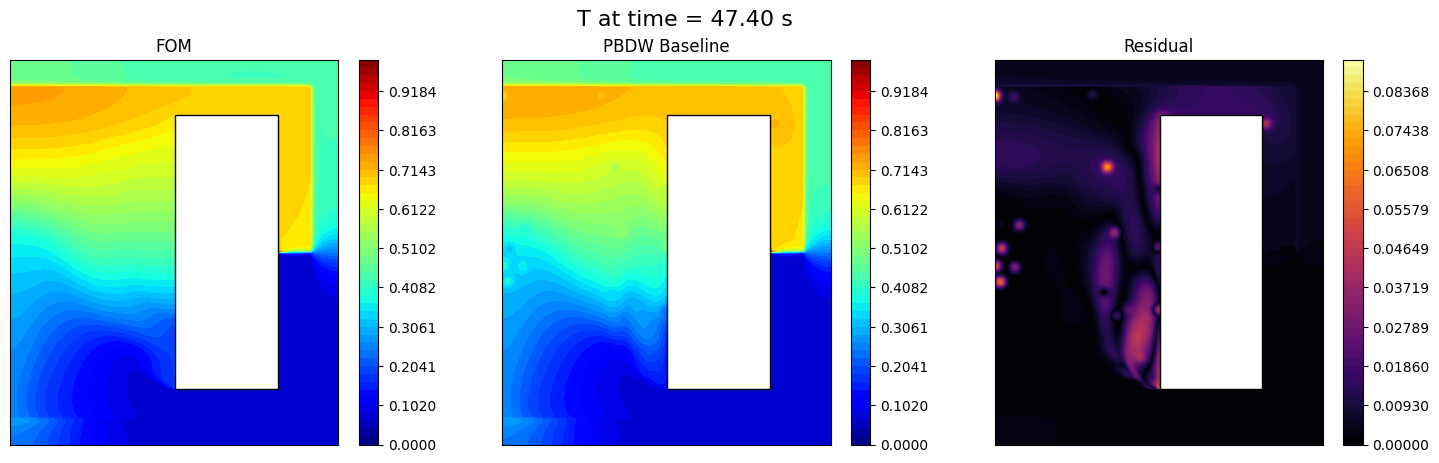

In [27]:
from IPython.display import clear_output
for tt in range(0, len(test_times), 10):

    fig, axs = plt.subplots(1, 3, figsize=(6*3,5))

    c = plot_contour(axs[0], nodes, test_snaps[tt],levels = np.linspace(0, 1, 50))
    plot_contour(axs[1], nodes, pbdw_estimation['baseline'][tt], levels = np.linspace(0, 1, 50))

    fig.colorbar(c, ax=axs[0])
    fig.colorbar(c, ax=axs[1])

    # Residual
    residual = np.abs(test_snaps[tt] - pbdw_estimation['baseline'][tt])
    c = plot_contour(axs[2], nodes, residual, levels = np.linspace(0, np.max(residual), 50), cmap=cm.inferno)
    fig.colorbar(c, ax=axs[2])

    # Labels
    axs[0].set_title('FOM')
    axs[1].set_title('PBDW Baseline')
    axs[2].set_title('Residual')

    fig.suptitle(field+' at time = %.2f s' % (test_times[tt]), fontsize=16)

    plt.show()
    clear_output(wait=True)
    plt.close(fig)

### Online Phase: failing sensors
Now, we simulate failing sensors. We consider both hard failures and drift failures.

The class is initialized as before.

In [28]:
from pyforce.online.failure_sens import FailingPBDW

failing_pbdw_on = FailingPBDW(grid, varname=field)

failing_pbdw_on.set_basis(pod_off.pod_modes)
failing_pbdw_on.set_basis_sensors(sgreedy_off.sensors.library)

# Assemble matrix for online phase
failing_pbdw_on.compute_matrices()

**Drift failures** are simulated by adding a bias and variance to the measurements of the failed sensors.
Let us compute the test errors with drift failures on a single sensor. The total number of sensors used is 20 as the number of basis and the influence of the failed index is investigated.

In [36]:
pbdw_on_abs_err['drift'] = list()
pbdw_on_rel_err['drift'] = list()
pbdw_estimation['drift'] = list()

snaps_norm = list()
for _snap in test_snaps:
    snaps_norm.append(failing_pbdw_on.calculator.L2_norm(_snap))

for kk in range(len(failing_pbdw_on.sensors)):

    print(f"Simulating drift failure on sensor {kk+1}/{len(failing_pbdw_on.sensors)}", end='\r')

    drift_dict = {
        'kappa': kappa_drift,
        'rho': rho_drift,
        'idx_failed': [kk],
        'mu_failure': 0
    }

    drifted_mea = failing_pbdw_on.get_measurements(test_snaps, noise_std=noise_std, drift_dict=drift_dict)
    pbdw_estimation['drift'].append(failing_pbdw_on.estimate(   drifted_mea ))
    
    _abs_err = list()
    _rel_err = list()
    for tt in range(len(test_snaps)):
        _abs_err.append( 
            failing_pbdw_on.calculator.L2_norm(pbdw_estimation['drift'][-1](tt) - test_snaps(tt))
        )
        _rel_err.append( 
            _abs_err[-1] / snaps_norm[tt]
        )

    pbdw_on_abs_err['drift'].append(np.mean(_abs_err))
    pbdw_on_rel_err['drift'].append(np.mean(_rel_err))

**Hard failures** are simulated by removing the measurements of the failed sensors.

In [37]:
pbdw_on_abs_err['hard'] = list()
pbdw_on_rel_err['hard'] = list()
pbdw_estimation['hard'] = list()

snaps_norm = list()
for _snap in test_snaps:
    snaps_norm.append(failing_pbdw_on.calculator.L2_norm(_snap))

for kk in range(len(failing_pbdw_on.sensors)):

    print(f"Simulating hard failure on sensor {kk+1}/{len(failing_pbdw_on.sensors)}", end='\r')

    hard_failure_dict = {
        'mu_failure': 0,
        'idx_failed': [kk]
    }

    # Get measurements
    measures = failing_pbdw_on.get_measurements(test_snaps, noise_std=noise_std)

    # Estimate the state
    pbdw_estimation['hard'].append(
        failing_pbdw_on.estimate(   measures, 
                                    hard_failure_dict=hard_failure_dict)
                                    )

    # Compute errors

    _abs_err = list()
    _rel_err = list()
    for tt in range(len(test_snaps)):
        _abs_err.append( 
            failing_pbdw_on.calculator.L2_norm(pbdw_estimation['hard'][-1](tt) - test_snaps(tt))
        )
        _rel_err.append( 
            _abs_err[-1] / snaps_norm[tt]
        )

    pbdw_on_abs_err['hard'].append(np.mean(_abs_err))
    pbdw_on_rel_err['hard'].append(np.mean(_rel_err))

Let us plot the errors obtained with drift failures, with respect to the baseline (no failing sensors)

Text(0.5, 0.98, 'PBDW with Failing Sensors')

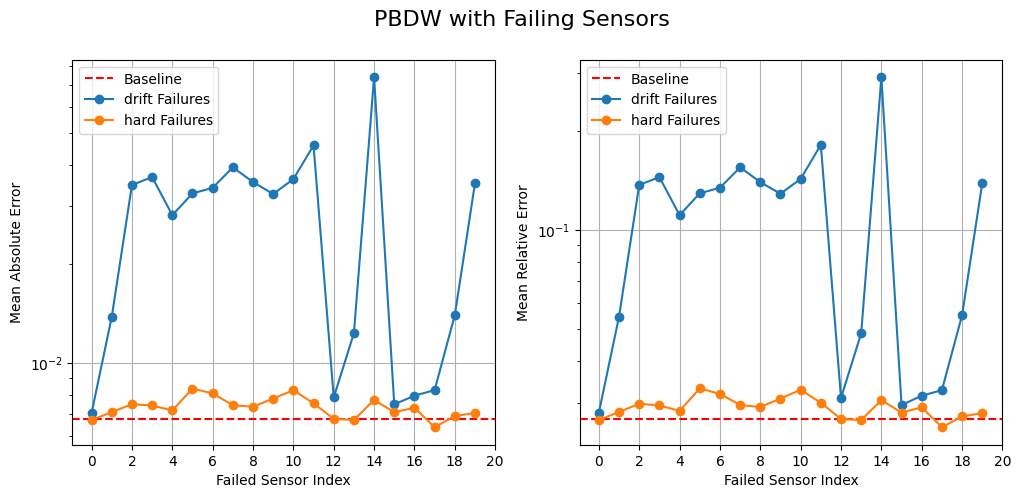

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Baseline
axs[0].axhline(pbdw_on_abs_err['baseline'][-1], color='red', linestyle='--', label='Baseline')
axs[1].axhline(pbdw_on_rel_err['baseline'][-1], color='red', linestyle='--', label='Baseline')

# Drift failures
for failure in ['drift', 'hard']:
    axs[0].plot(pbdw_on_abs_err[failure], marker='o', label=failure + ' Failures')
    axs[1].plot(pbdw_on_rel_err[failure], marker='o', label=failure + ' Failures')

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_xticks(range(0, len(failing_geim_on.basis)+1, 2))
    ax.set_xlabel('Failed Sensor Index')
    ax.set_yscale('log')

axs[0].set_ylabel('Mean Absolute Error')
axs[1].set_ylabel('Mean Relative Error')

fig.suptitle('PBDW with Failing Sensors', fontsize=16)

Let us plot the reconstructions

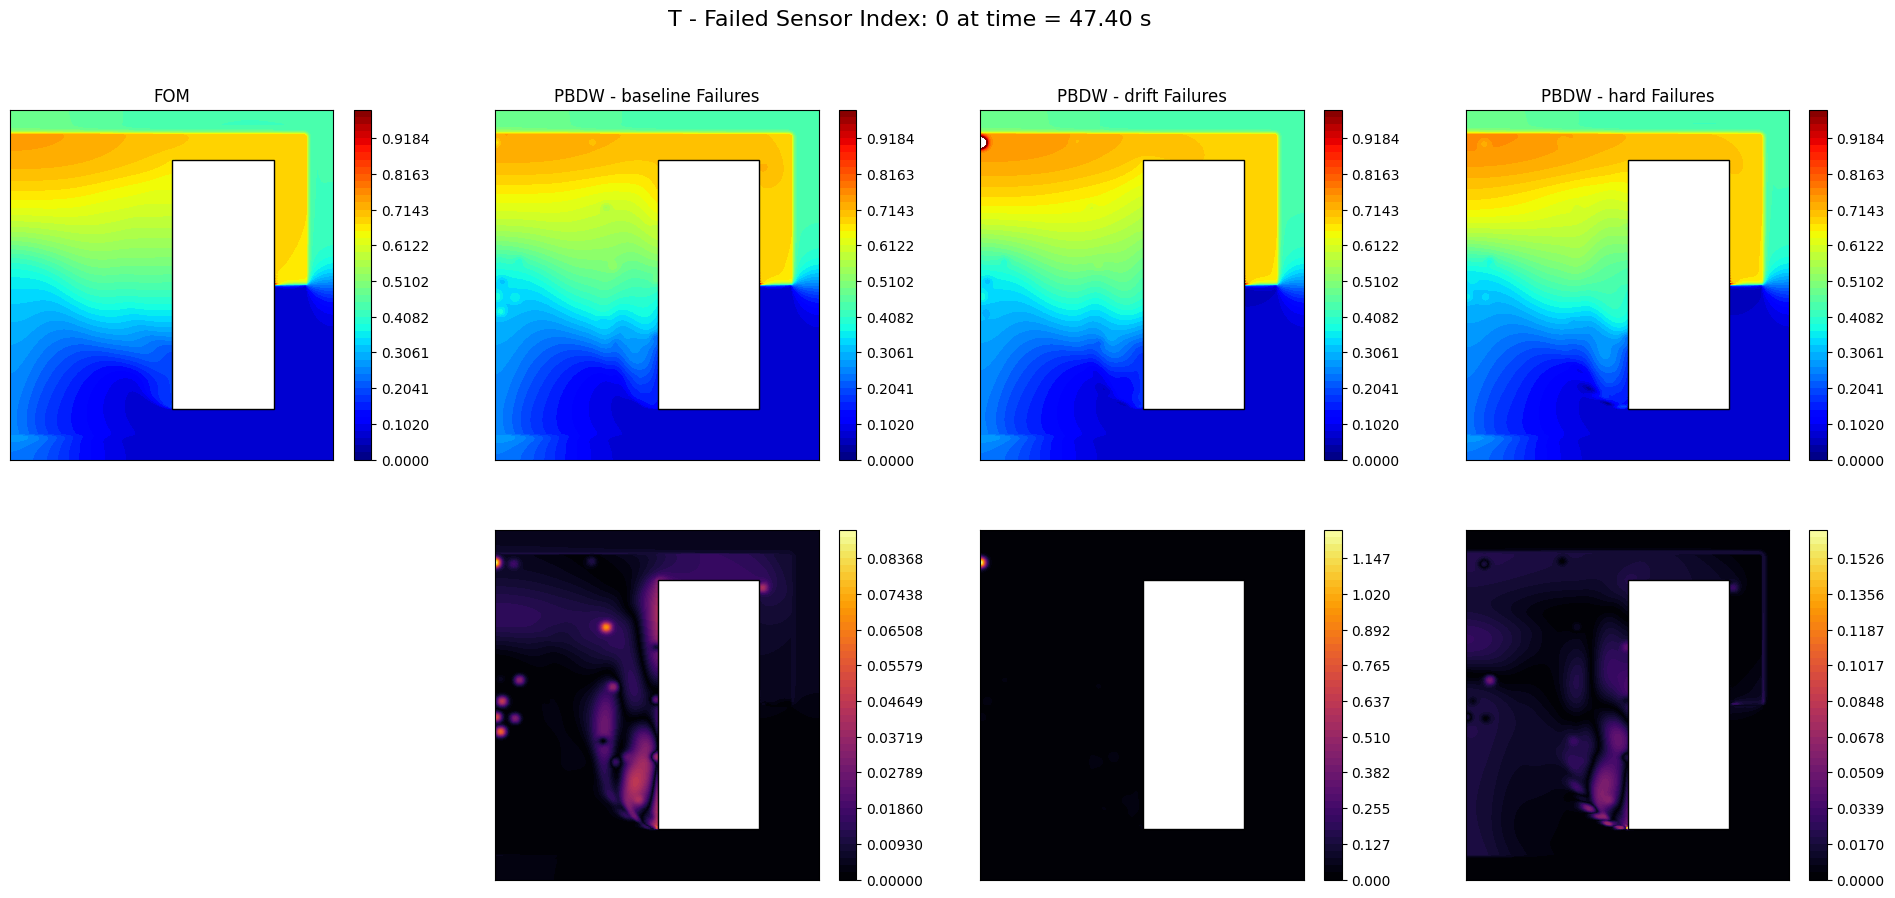

In [52]:
from IPython.display import clear_output

ncols = len(pbdw_estimation)+1
nrows = 2

_idx_failed_to_plot = 0

for tt in range(0, len(test_times), 10):

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5 * nrows))

    c = plot_contour(axs[0,0], nodes, test_snaps[tt],levels = np.linspace(0, 1, 50))
    fig.colorbar(c, ax=axs[0,0])
    axs[0,0].set_title('FOM')

    for i, (key, estimation) in enumerate(pbdw_estimation.items()):

        if key == 'baseline':
            _est = estimation
        else:
            _est = estimation[_idx_failed_to_plot]

        c = plot_contour(axs[0,i+1], nodes, _est[tt], levels = np.linspace(0, 1, 50))
        fig.colorbar(c, ax=axs[0, i+1])

        # Residual
        residual = np.abs(test_snaps[tt] - _est[tt])
        c = plot_contour(axs[1,i+1], nodes, residual, levels = np.linspace(0, np.max(residual), 50), cmap=cm.inferno)
        fig.colorbar(c, ax=axs[1,i+1])

        axs[0, i+1].set_title(f'PBDW - {key} Failures')

    fig.suptitle(field+' - Failed Sensor Index: %d at time = %.2f s' % (_idx_failed_to_plot, test_times[tt]), fontsize=16)
    axs[1,0].axis('off')

    plt.show()
    clear_output(wait=True)
    plt.close(fig)